## Getting the mass of the Z Boson

We see at the sample dataset recorded by CMS in 2011 and was published at CERN opendata portal. It comes from the DoubleMuon dataset with:


1.   Both muons are "global" muons
2.   Invariant mass sits in range: $60 MeV < M_{\mu\mu} < 120 GeV$
3.  $|\eta| < 2.1$ for both the muons.
4.  $p_t > 20 GeV$





### What does the CSV file contains?



*   Run : Event are the run and event numbers, respectively



*   $p_t$ : It is the transverse momentum of the muon
*   $\eta$ : It is the pseudorapidity of the muon $\eta$



*   $\phi$ : It is the angle of the muon direction.
*   Q : Is the charge of the muon.



*   $d xy$ : It is the impact parameter in the transverse plane, how distant is the track from the collision point.
*   iso : It is the track isolation , how many other tracks are there around the given track.









#### Doing the basic imports

In [3]:
# doing the basic imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skopt import gp_minimize
%matplotlib inline

#### Read the dataset available.
Get the dataset from [here](http://opendata.cern.ch/record/545)

In [4]:
df = pd.read_csv('zmass.csv')
df.shape

(10000, 14)

In [5]:
df

,Run,Event,pt1,eta1,phi1,Q1,dxy1,iso1,pt2,eta2,phi2,Q2,dxy2,iso2
0,165617,74969122,54.7055,-0.4324,2.5742,1,-0.0745,0.4999,34.2464,-0.9885,-0.4987,-1,0.0712,3.4221
1,165617,75138253,24.5872,-2.0522,2.8666,-1,-0.0554,0.0000,28.5389,0.3852,-1.9912,1,0.0515,0.0000
2,165617,75887636,31.7386,-2.2595,-1.3323,-1,0.0879,0.0000,30.2344,-0.4684,1.8833,1,-0.0876,0.0000
3,165617,75779415,39.7394,-0.7123,-0.3123,1,0.0585,0.0000,48.2790,-0.1956,2.9703,-1,-0.0492,0.0000
4,165617,75098104,41.2998,-0.1571,-3.0408,1,-0.0305,1.2280,43.4508,0.5910,-0.0428,-1,0.0442,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,173692,1245050481,8.9721,-1.6158,-2.7176,1,-0.0294,8.7183,13.5266,1.8709,2.7911,1,-0.0689,0.4202
9996,173692,1244979327,39.4543,-1.1310,-2.0568,1,0.0417,0.0000,47.7209,-0.1834,1.7965,-1,-0.0794,0.0000
9997,173692,1245305163,40.6034,-1.5051,-1.6758,-1,0.0635,0.2012,44.4382,-1.0010,1.5380,1,-0.0671,1.1499
9998,173692,1245041468,37.2853,1.0024,-2.1486,1,0.0361,0.0000,41.0945,-0.1200,0.8850,-1,-0.0291,0.0000


##### How the invariant mass of two muons is calculated?

$ M = \sqrt{2p_t^1 p_t^2 (\cosh (\eta_1 - \eta_2) - \cos(\phi_1 -\phi_2))}$

Write the same in the python block.

In [7]:
# create a new column in the dataset which
# contain the invariant mass

df['M'] = np.sqrt(2 * df['pt1'] * df['pt2'] * (np.cosh(df['eta1'] - df['eta2']) - np.cos(df['phi1'] - df['phi2'])))
df.head(5)

,Run,Event,pt1,eta1,phi1,Q1,dxy1,iso1,pt2,eta2,phi2,Q2,dxy2,iso2,M
0,165617,74969122,54.7055,-0.4324,2.5742,1,-0.0745,0.4999,34.2464,-0.9885,-0.4987,-1,0.0712,3.4221,89.885919
1,165617,75138253,24.5872,-2.0522,2.8666,-1,-0.0554,0.0000,28.5389,0.3852,-1.9912,1,0.0515,0.0000,88.812177
2,165617,75887636,31.7386,-2.2595,-1.3323,-1,0.0879,0.0000,30.2344,-0.4684,1.8833,1,-0.0876,0.0000,88.474683
3,165617,75779415,39.7394,-0.7123,-0.3123,1,0.0585,0.0000,48.2790,-0.1956,2.9703,-1,-0.0492,0.0000,90.332429
4,165617,75098104,41.2998,-0.1571,-3.0408,1,-0.0305,1.2280,43.4508,0.5910,-0.0428,-1,0.0442,0.0000,90.515882


### Model
The distribution of the Z-boson mass has the form of a normal distribution, in addition there's noise, and the distribution of the noise has an exponential form. Hence the resulting form will be a superposition of both the distributions.

Now, let's plot the distribution

In [8]:
# function to plot

def plot_mass(mass, bins_count=100):
  y,x = np.histogram(mass, bins = bins_count, density = False)
  err = np.sqrt(y)


  fig = plt.figure(figsize = (16,8))
  plt.title('Z-Boson Mass', fontsize=21)
  plt.xlabel("$m_{\mu\mu}$ [GeV]", fontsize = 21)
  plt.ylabel("Number of events", fontsize=21)
  plt.errorbar(x[:-1], y , yerr = err, fmt = 'o', color ='blue' ,ecolor='grey', capthick=0.5, zorder=1, label="data")
  return y, x

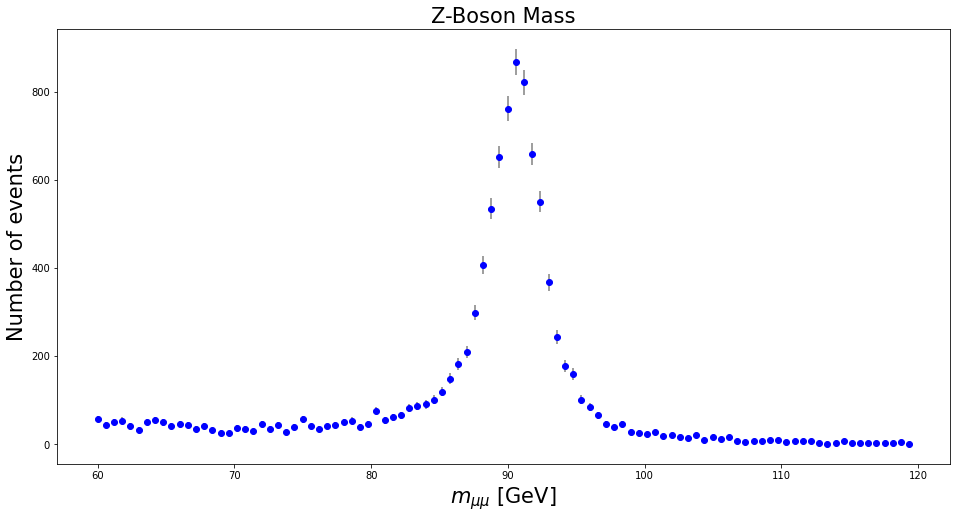

In [10]:
# now plot the invariant mass
# the ";" is added to only print the plot, not the entire data 
plot_mass(df.M);

### Clean up the dataset

We need certain criteria to be met.


1.   We need that the charge of two muons considered should be opposite.
2.   We want the $I_{track} < 3$ and $d_{xy} < 0.2 cm$



In [11]:
df_sign = df[((df.Q1 > 0) & (df.Q2 < 0)) | ((df.Q1 < 0) & (df.Q2 > 0))]

In [13]:
df_isolation = df_sign[(df_sign.iso1 < 3) & (df_sign.iso2 < 3) & (df_sign.dxy1.abs() < 0.2) & (df_sign.dxy2.abs() < 0.2)]

In [14]:
df = df_isolation

In [15]:
df.head(5)

,Run,Event,pt1,eta1,phi1,Q1,dxy1,iso1,pt2,eta2,phi2,Q2,dxy2,iso2,M
1,165617,75138253,24.5872,-2.0522,2.8666,-1,-0.0554,0.000,28.5389,0.3852,-1.9912,1,0.0515,0.0,88.812177
2,165617,75887636,31.7386,-2.2595,-1.3323,-1,0.0879,0.000,30.2344,-0.4684,1.8833,1,-0.0876,0.0,88.474683
3,165617,75779415,39.7394,-0.7123,-0.3123,1,0.0585,0.000,48.2790,-0.1956,2.9703,-1,-0.0492,0.0,90.332429
4,165617,75098104,41.2998,-0.1571,-3.0408,1,-0.0305,1.228,43.4508,0.5910,-0.0428,-1,0.0442,0.0,90.515882
5,165617,77255513,38.9425,0.3522,-2.2649,-1,0.0384,0.000,39.8616,0.2630,0.9183,1,-0.0407,0.0,78.860090


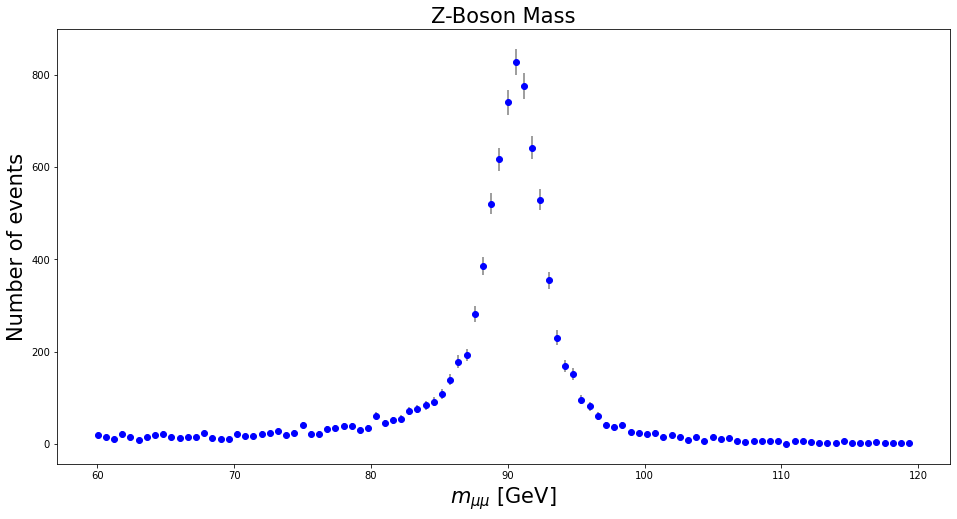

In [16]:
plot_mass(df.M);

### Parameterised Model
Our model will be a mixture of


1.   Gaussian Signal
2.   Exponential noise signal

So, we get the following parameters:


*   $m_0$ : center of the gaussian
*   $\sigma$ : standard deviation of the gaussian
*   amplitude : height of the peak
*  bck : height of the background


Finding these parameters is called the $fitting$ model into the data.





In [17]:
def model_predict(params, X):
  m0, sigma, ampl, bck = params
  return bck+ ampl /(sigma * np.sqrt(2* np.pi))  * np.exp((-1) * (X - m0)**2 / (2 * sigma**2))


In [18]:
def model_loss(params, X, y):
   residuals = y - model_predict(params,X)
   return np.sum(residuals**2)/ len(residuals)

In [19]:
def plot_mass_with_model(params, mass, bins_count=100):
    y, X = plot_mass(mass, bins_count=bins_count)
    X = (X[1:] + X[:-1]) / 2
    error = model_loss(params, X, y)
    plt.plot(X, model_predict(params, X), color='blue', linewidth=3.0, zorder=2, label="fit, loss=%.2f" % error)
    plt.legend(fontsize='x-large')

### Fitting the model parameters using Scikit Optimizer

In [20]:
from tqdm import tqdm
from skopt import Optimizer

search_space = [(30.0, 180.0), # m0 range
    (0.5, 10.0), # sigma range
    (2000, 8000), # amplitude range
    (0, 50) # bck range
    ]
y, X = np.histogram(df.M, bins=120, density=False)
X = (X[1:] + X[:-1]) / 2
opt = Optimizer(search_space, base_estimator="GP", acq_func="EI", acq_optimizer="lbfgs")

In [21]:
from skopt.utils import create_result
for i in tqdm(range(50)):
    next_x = opt.ask()
    f_val = model_loss(next_x, X, y)
    opt.tell(next_x, f_val)
    
res = create_result(Xi=opt.Xi, yi=opt.yi, space=opt.space,
                         rng=opt.rng, models=opt.models)

100%|██████████| 50/50 [00:24<00:00,  2.02it/s]


### The search history

[('m0', 90.35845303809043), ('sigma', 3.0355178505954794), ('ampl', 3351), ('bck', 2)]


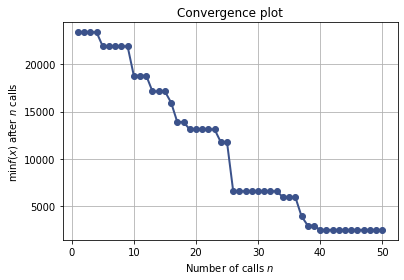

In [22]:
import skopt.plots
skopt.plots.plot_convergence(res)
print (list(zip(["m0", "sigma", "ampl", "bck"], res.x)))

How well our prediction fits the model?

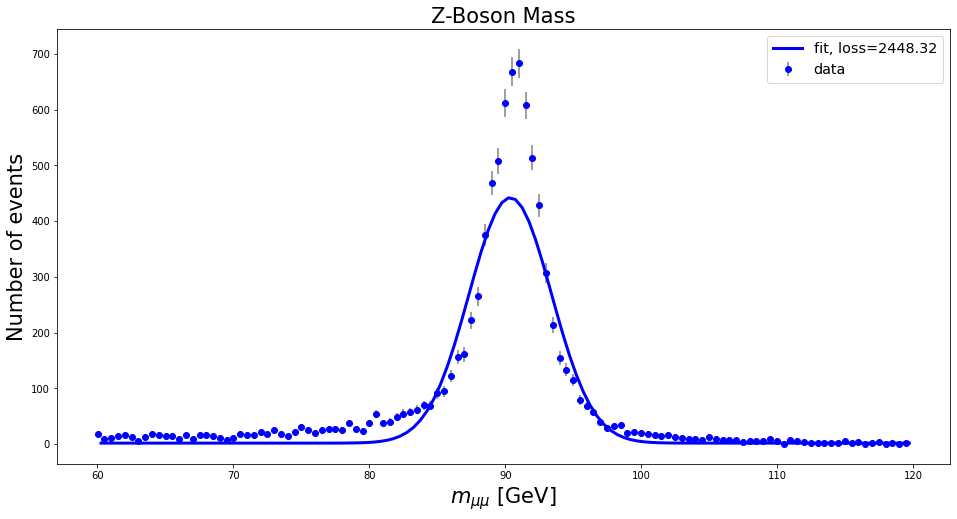

In [23]:
plot_mass_with_model(res.x, df.M, bins_count=120)